In [1]:
# Cell 1: Install necessary libraries if not already available
!pip install datasets transformers evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.9 MB/s eta 0:00:0000:01


In [2]:
# Cell 2: Import libraries, configure warnings, and set up configurations
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", message="Was asked to gather along dimension 0")

from datasets import Dataset, DatasetDict
import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)

In [3]:
# Cell 3: Data setup
DATA_PATH = "/kaggle/input/touche-task4-2025-subtask2/touche-task4-2025-subtask2"
train_responses_file = os.path.join(DATA_PATH, "responses-train.jsonl")
train_labels_file = os.path.join(DATA_PATH, "responses-train-labels.jsonl")
val_responses_file = os.path.join(DATA_PATH, "responses-validation.jsonl")
val_labels_file = os.path.join(DATA_PATH, "responses-validation-labels.jsonl")
test_responses_file = os.path.join(DATA_PATH, "responses-test.jsonl")
test_labels_file = os.path.join(DATA_PATH, "responses-test-labels.jsonl")

def load_jsonl(file_path):
    """Load a JSONL file and return a list of dicts."""
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                data.append(json.loads(line))
    return data

def merge_data(responses_file, labels_file):
    """Merge responses and labels using the response id."""
    responses = load_jsonl(responses_file)
    labels = load_jsonl(labels_file)
    label_map = {item["id"]: item["label"] for item in labels}
    
    merged = []
    for resp in responses:
        rid = resp["id"]
        if rid in label_map:
            merged.append({
                "id": rid,
                "text": resp["response"],
                "label": label_map[rid]
            })
    return merged


In [4]:
# Cell 4: Create Hugging Face Datasets for train/validation/test
train_data = merge_data(train_responses_file, train_labels_file)
val_data = merge_data(val_responses_file, val_labels_file)
test_data = merge_data(test_responses_file, test_labels_file)

train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)
test_dataset = Dataset.from_list(test_data)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 11487
    })
    validation: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 2600
    })
})


In [5]:
# Cell 5: Tokenize using RoBERTa tokenizer for the ad detector model
# Update the model checkpoint to use RoBERTa large. If you have a fine-tuned large version,
# replace "roberta-large" with your custom checkpoint name.
model_checkpoint = "roberta-large"
tokenizer = AutoTokenizer.from_pretrained("roberta-large")

def tokenize_function(examples):
    # Use a maximum length of 512 tokens
    return tokenizer(examples["text"], truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["id", "text"])

# Suppress the sentencepiece warning
warnings.filterwarnings("ignore", message="The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/11487 [00:00<?, ? examples/s]

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/2600 [00:00<?, ? examples/s]

In [6]:
# Cell 6: Create the model and data collator
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Cell 7: Define evaluation metrics and configure the Trainer
import evaluate

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=predictions, references=labels, average="binary")["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average="binary")["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="binary")["f1"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,       # Reduced batch size to lower memory usage
    per_device_eval_batch_size=8,        # Reduced evaluation batch size as well
    gradient_accumulation_steps=8,       # Accumulate gradients to simulate a larger effective batch size
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    fp16=True                          # Enable mixed precision training for memory efficiency
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-bbd753bbb2f5>:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [8]:
# Cell 8: Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.059500,0.020727,0.995088,0.990741,0.995770,0.993249
2,0.006900,0.025999,0.995088,0.998291,0.988156,0.993197


TrainOutput(global_step=537, training_loss=0.06671430434150624, metrics={'train_runtime': 4165.8063, 'train_samples_per_second': 8.272, 'train_steps_per_second': 0.129, 'total_flos': 2.112555891673853e+16, 'train_loss': 0.06671430434150624, 'epoch': 2.986072423398329})

In [9]:
# Cell 9: Evaluate on the test set
test_metrics = trainer.evaluate(tokenized_datasets["test"])
print("Test set metrics:", test_metrics)

Test set metrics: {'eval_loss': 0.042427126318216324, 'eval_accuracy': 0.9911538461538462, 'eval_precision': 0.9836956521739131, 'eval_recall': 0.9912376779846659, 'eval_f1': 0.9874522640480088, 'eval_runtime': 86.924, 'eval_samples_per_second': 29.911, 'eval_steps_per_second': 3.739, 'epoch': 2.986072423398329}


In [10]:
# Cell 10: Save the fine-tuned model and tokenizer
# Note: Update the save path name to reflect that this is a large model
model_save_path = "./roberta-large-ad-detector-finetuned"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./roberta-large-ad-detector-finetuned


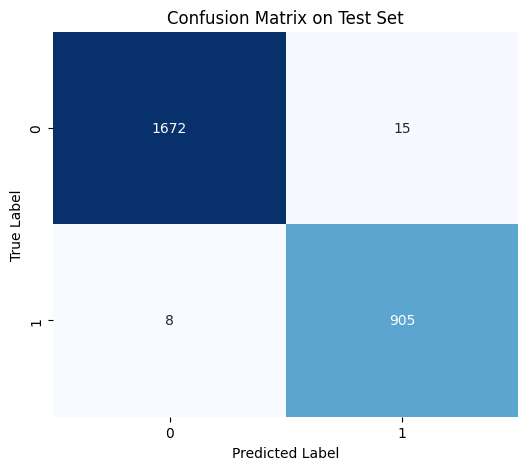

In [11]:
# Cell 11: Compute and plot the confusion matrix for the test set
test_output = trainer.predict(tokenized_datasets["test"])
predictions = test_output.predictions.argmax(axis=-1)
true_labels = test_output.label_ids

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


In [2]:
# Cell 12 (Updated): Extract training loss logs and plot average loss per epoch
epoch_loss = {}
for entry in log_history:
    if "epoch" in entry and "loss" in entry:
        epoch = int(entry["epoch"])  # Group by integer epochs
        if epoch not in epoch_loss:
            epoch_loss[epoch] = []
        epoch_loss[epoch].append(entry["loss"])

# Calculate average loss per integer epoch
sorted_epochs = sorted(epoch_loss.keys())
sorted_loss = [sum(epoch_loss[epoch])/len(epoch_loss[epoch]) for epoch in sorted_epochs]

plt.figure(figsize=(8,5))
plt.plot(sorted_epochs, sorted_loss, marker="o", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Training Loss vs. Epoch")
plt.grid(True)
plt.xticks(sorted_epochs)  # Ensure only integer epochs are labeled
plt.show()

NameError: name 'log_history' is not defined